# ENRON

## Preparations

In [94]:
#!/usr/bin/python

# importing libraries
import sys
import pickle
import pprint
import numpy as np
import pandas as pd
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

%matplotlib inline
from matplotlib import pyplot as plt

In [95]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [96]:
# preparing a pandas DF for easier access
enron_df = pd.DataFrame(data_dict)
# better in the other format
enron_df = enron_df.transpose()

In [97]:
# what does it mean that all columns are dtype 'object'?
#enron_df.dtypes

In [98]:
# removing the email-address column because it has no predicitve power
enron_df = enron_df.drop('email_address', 1)

In [99]:
# setting the initial features list
features_list = list(enron_df.columns.values)

In [100]:
nr_poi = len(enron_df[enron_df.poi == 1])
nr_non_poi = len(enron_df[enron_df.poi == 0])
print "total number of data points:", len(enron_df)
print "of which {0} are POI and {1} are non-POI.".format(nr_poi, nr_non_poi)

total number of data points: 146
of which 18 are POI and 128 are non-POI.


In [101]:
# the ratio that non-POI are more frequent in the dataset than POI
# this means we are dealing with a highly imbalanced dataset
ratio_poi = nr_non_poi / nr_poi
print "non-POI are {0} times more frequent than POI".format(ratio_poi)

non-POI are 7 times more frequent than POI


## Outlier Removal

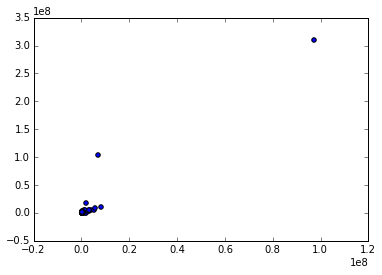

In [102]:
plt.scatter(enron_df['bonus'], enron_df['total_payments'])

In [103]:
# 'NaN' are encoded as string instead of nan - I change this to work with them easier
enron_df.replace(['NaN'], [None], inplace=True)

In [104]:
outlier = enron_df['bonus'].max()
#print enron_df.loc[enron_df['bonus'] == outlier]
# this shows that the entry is TOTAL, and can be removed
enron_df = enron_df[enron_df.bonus != outlier]

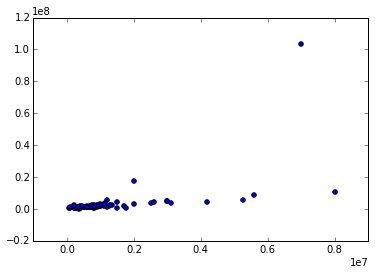

In [105]:
plt.scatter(enron_df['bonus'], enron_df['total_payments'])

In [106]:
# repeat
outlier = enron_df.total_payments.max()
print enron_df.total_payments.loc[enron_df.total_payments == outlier]
# shows that this outlier is valid and should remain in the dataset

LAY KENNETH L    103559793
Name: total_payments, dtype: float64


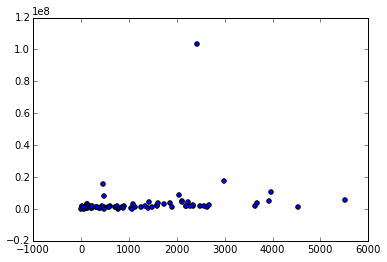

In [107]:
plt.scatter(enron_df.shared_receipt_with_poi, enron_df.total_payments)

In [108]:
def display_outlier(column_name):
    """prints the max value in a df column of the name passed as arg."""
    outlier = enron_df[column_name].max()
    print enron_df.loc[enron_df[column_name] == outlier]
    
#display_outlier('shared_receipt_with_poi')
# this shows that the datapoint is a valid person

In [109]:
# shows that this manually found datapoint is not a person, therefore I remove it
#print enron_df.loc["THE TRAVEL AGENCY IN THE PARK"]

agency = "THE TRAVEL AGENCY IN THE PARK"
enron_df = enron_df.drop([agency])

## Engineering a new feature

In [110]:
def email_perc(row):
    """calculates the ratio of emails sent to a POI vs. emails received from a POI.
    
    takes as input one row of a dataframe
    returns the ratio as a floating point number.
    """
    one_way = row['from_this_person_to_poi']
    the_other = row['from_poi_to_this_person']
    
    ratio = 0
    # calculating the ratio only if there is no 0 value involved
    if one_way != 0 and the_other != 0:
        ratio = float(one_way) / the_other
    return ratio

In [111]:
# generating the feature of interest
enron_df["sent_received_ratio"] = enron_df.apply(lambda row: email_perc(row), axis=1)

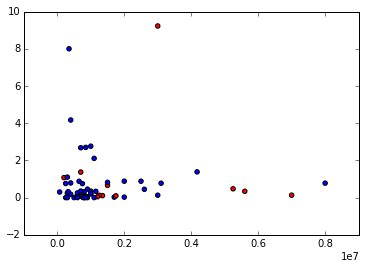

In [112]:
# visualizing the new feature, while accounting for the POI and non-POI in the dataset
# POI are displayed as red circles, non-POI as blue circles
use_colors = {0: "blue", 1: "red"}
cPOI = np.array(enron_df[['poi']])
plt.scatter(enron_df.bonus, enron_df.sent_received_ratio, c=[use_colors[z[0]] for z in cPOI])

In [113]:
# updating the features list with the new feature
# and moving 'poi' to the 0th place
features_list.append("sent_received_ratio")
features_list = features_list[12:] + features_list[:12]
features_list

['poi',
 'restricted_stock',
 'restricted_stock_deferred',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value',
 'sent_received_ratio',
 'bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'loan_advances',
 'long_term_incentive',
 'other']

## More Wrangling

In [115]:
# the classifiers cannot handle NaN values, therefore they need to be either removed or imputed
# also due to the small size of the dataset I chose to impute values
# creating a copy of the original df for imputing
enron_imp = enron_df

In [116]:
# email-corpus data (and features generated from it) receive the median (no value != 0)
# from_messages, from_poi_to_this_person, from_this_person_to_poi, to_messages, sent_received_ratio
enron_imp.from_messages.fillna(enron_imp.from_messages.median(), inplace=True)
enron_imp.from_poi_to_this_person.fillna(enron_imp.from_poi_to_this_person.median(), inplace=True)
enron_imp.from_this_person_to_poi.fillna(enron_imp.from_this_person_to_poi.median(), inplace=True)
enron_imp.to_messages.fillna(enron_imp.to_messages.median(), inplace=True)
enron_imp.sent_received_ratio.fillna(enron_imp.sent_received_ratio.median(), inplace=True)

In [117]:
# financial data (and features generated from it) receive 0 (no value most likely == 0)
# since all the email-corpus data NaNs are now filled, I can impute the remaining NaN
# in the dataframe with 0
enron_imp.fillna(0, inplace=True)
# here's the imputed df
enron_imp.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,...,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,sent_received_ratio
ALLEN PHILLIP K,4175000,2869717,-3081055,0,1729541,13868,2195,47,65,0,...,152,False,126027,-126027,201955,1407,2902,4484442,1729541,1.382979
BADUM JAMES P,0,178980,0,0,257817,3486,41,35,8,0,...,0,False,0,0,0,0,1211,182466,257817,0.180195
BANNANTINE JAMES M,0,0,-5104,0,4046157,56301,29,39,0,0,...,864523,False,1757552,-560222,477,465,566,916197,5243487,0.000000
BAXTER JOHN C,1200000,1295738,-1386055,0,6680544,11200,41,35,8,0,...,2660303,False,3942714,0,267102,0,1211,5634343,10623258,0.180195
BAY FRANKLIN R,400000,260455,-201641,0,0,129142,41,35,8,0,...,69,False,145796,-82782,239671,0,1211,827696,63014,0.180195


In [118]:
# translating back to a dict for easier work with the lesson code
imp_dataset = enron_imp.to_dict(orient='index')

## Feature Selection

In [119]:
# I'll be using an overfit Decision Tree to calculate the feature importances

def get_most_important_features(dataset, features_list):
    """Calculates the feature importances.
    
    Takes as input a dataset and a list of features.
    Creates an overfit Decision Tree and calculates the feature importances.
    Returns a list with the feature importances.
    """
    # creating an overfitted decision tree
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import accuracy_score

    data = featureFormat(dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
        
    # new features filtered, NaN values removed
    features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                                    labels,
                                                                                    test_size=0.3,
                                                                                    random_state=42)

    clf = DecisionTreeClassifier()
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    acc = accuracy_score(labels_test, pred)
    # uncomment to print the accuracy score
    #print "overfitted accuracy", acc

    # calculating feature importances
    feat_imp = clf.feature_importances_
    # uncomment to print the most important (common) ones
    #print feat_imp
    #for index, feature in enumerate(feat_imp):
    #    if feature > 0.2:
    #        print "spot:", index, ":", features_list[index+1], " | value:", feature
    return feat_imp

In [120]:
# collecting the values to calculate the average feature importances
feat_imp_list_list = []

for i in range(100):
    feat_imp = get_most_important_features(imp_dataset, features_list)
    feat_imp_list_list.append(feat_imp)

In [121]:
feature_compare = features_list[1:]
feat_imp_dict = {}

for f in feature_compare:
    feat_imp_dict[f] = []

for array in feat_imp_list_list:
    for index, number in enumerate(array):
        feat_imp_dict[feature_compare[index]].append(number)

In [122]:
top_feat_imp = {}
threshold = 0.1
# getting the average of all runs and storing the ones passing the threshold in a dictionary
for key, value in feat_imp_dict.items():
    mean = np.asarray(value).mean()
    print key, ":", mean
    if mean > threshold:
        top_feat_imp[key] = mean

salary : 0.00810492189803
to_messages : 0.0
sent_received_ratio : 0.0255305039788
deferral_payments : 0.0201149425287
total_payments : 0.0539935160625
loan_advances : 0.0
bonus : 0.292259909742
long_term_incentive : 0.0499852637784
restricted_stock_deferred : 0.0
total_stock_value : 0.00589448865311
shared_receipt_with_poi : 0.0
from_poi_to_this_person : 0.0317197170645
exercised_stock_options : 0.0125257883879
from_messages : 0.0
other : 0.0583554376658
from_this_person_to_poi : 0.0
deferred_income : 0.178624057934
expenses : 0.160095936484
restricted_stock : 0.102795515822
director_fees : 0.0


In [123]:
pprint.pprint(top_feat_imp)

{'bonus': 0.29225990974186628,
 'deferred_income': 0.17862405793440281,
 'expenses': 0.1600959364837119,
 'restricted_stock': 0.10279551582233569}


In [124]:
# updating the features list with the top performers (those I will actually use)
features_list = ['poi'] + top_feat_imp.keys()

## Classifier

In [125]:
# preparing the data into training and testing sets
data = featureFormat(imp_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
# features after imputing values
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)
# combining the training and testing variables into a list for easier input for the function I wrote
full_feat_list = [features_train, features_test, labels_train, labels_test]

In [126]:
def test_classifier(classifier_obj, data, scale=False):
    """Measures the time and accuracy of a given classifier.
    
    Takes as input a classifiert object (tuned or untuned)
    and a list containing the training and testing features and labels
    in this form:
    data = [features_train, features_test, labels_train, labels_test]
    Prints processing time and overall accuracy score.
    """
    from time import time
    from sklearn.metrics import accuracy_score
    from sklearn.preprocessing import MinMaxScaler
    
    # scaling the data when the type of algorithm demands this
    if scale == True:
        scaler = MinMaxScaler()
        features_train = scaler.fit_transform(data[0])
        features_test = scaler.transform(data[1])
    else:
        features_train = data[0]
        features_test = data[1]
    labels_train = data[2]
    labels_test = data[3]
    
    ### uncomment for information about time performance and accuracy ###
    ## taking the time the algorithm runs
    #t0 = time()
    classifier_obj.fit(features_train, labels_train)
    #print "training time:", round(time()-t0, 3), "s"
    
    ## taking time for prediction
    #t1 = time()
    pred = classifier_obj.predict(features_test)
    #print "predicting time:", round(time()-t1, 3), "s"
    
    #acc = accuracy_score(labels_test, pred)
    #print "accuracy:", acc
    
    print construct_CM(labels_test, pred)
    print calculate_f1(labels_test, pred)

In [127]:
def get_CM_nums(true_labels, predictions, CM_type):
    """Calculates the number of elements in the different cells of a confusion matrix.

    Takes as input the true labels and the predictions, both as lists.
    Further a specification of the metric wanted as an abbreviated string:
    'TP' for True Positives, 'FP' for False Positives
    'TN' for True Negatives, 'FN' for False Negatives
    Returns the amount of the specified metric.
    """
    import numpy as np
    
    if CM_type == "TP" or CM_type == "TN":
        if CM_type == "TP":
            CM_type = 1
        elif CM_type == "TN":
            CM_type = 0
        cpp = [1 for j in zip(true_labels, predictions) if j[0] == j[1] and j[1] == CM_type]
    elif CM_type == "FP" or CM_type == "FN":
        if CM_type == "FP":
            CM_type = 1
        elif CM_type == "FN":
            CM_type = 0
        cpp = [1 for j in zip(true_labels, predictions) if j[0] != j[1] and j[1] == CM_type]
    else:
        print "error, please enter TP, TN, FP, or FN."
    num_cpp = np.sum(cpp)
    return int(num_cpp)

def construct_CM(true_labels, predictions):
    """Wrapper function to calculate the confusion matrix and returns a formatted string.

    Takes as input the true labels and the predictions, both as lists.
    Calls get_CM_nums() with all possible inputs (TP, FP, TN, FN)
    Returns a formatted string representing the confusion martrix that is easy to read.
    """
    num_TP = get_CM_nums(true_labels, predictions, "TP")
    num_TN = get_CM_nums(true_labels, predictions, "TN")
    num_FP = get_CM_nums(true_labels, predictions, "FP")
    num_FN = get_CM_nums(true_labels, predictions, "FN")

    return """confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  {0}  |  {3}
class  | No  |  {2}  |  {1}""".format(num_TP, num_TN, num_FP, num_FN)

def calculate_f1(true_labels, predictions):
    """Calculates statistical metrics for the classifier's prediction.
    
    Takes as input the true labels and the predictions, both as lists.
    Returns a string containing the scores for precision recall and the f1-score.
    """
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1_score =  f1_score(true_labels, predictions)
    return """precision: {0}
recall:    {1}
f1_score:  {2}""".format(precision, recall, f1_score)

In [128]:
def test_a_lot(training_test_list):
    """Wrapper function that calculates performance results for different classifiers and prints the results.
    
    Takes as input a list of test and training data in the following form:
    'training_test_list = [features_train, features_test, labels_train, labels_test]'
    Calls the functions test_classifier() on Naive Bayes, SVM, Decision Trees,
    and K-nearest neighbors (each with the default settings).
    Prints all results in formatted output.
    """
    from sklearn.naive_bayes import GaussianNB
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier

    print "PERFORMANCE RESULTS OF DIFFERENT CLASSIFIERS"
    ### Naive Bayes
    print "\n\n### NAIVE BAYES ###"
    clf = GaussianNB()
    test_classifier(clf, training_test_list)

    ### Support Vector Machines
    print "\n\n### SUPPORT VECTOR MACHINES ###"
    # adapting the class_weight to reflect the imbalanced dataset of 1:7
    clf = SVC()
    test_classifier(clf, training_test_list, scale=True)

    ### Decision Trees
    print "\n\n### DECISION TREES ###"
    clf = DecisionTreeClassifier(class_weight='auto')
    test_classifier(clf, training_test_list)

    ### K-nearest Neighbours
    print "\n\n### K-NEAREST NEIGHBORS ###"
    neigh = KNeighborsClassifier()
    test_classifier(neigh, training_test_list, scale=True)

In [129]:
test_a_lot(full_feat_list)

PERFORMANCE RESULTS OF DIFFERENT CLASSIFIERS


### NAIVE BAYES ###
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  4
class  | No  |  2  |  34
precision: 0.0
recall:    0.0
f1_score:  0.0


### SUPPORT VECTOR MACHINES ###
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  4
class  | No  |  0  |  36
precision: 0.0
recall:    0.0
f1_score:  0.0


### DECISION TREES ###
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  2  |  2
class  | No  |  4  |  32
precision: 0.333333333333
recall:    0.5
f1_score:  0.4


### K-NEAREST NEIGHBORS ###
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  4
class  | No  |  1  |  35
precision: 0.0
recall:    0.0
f1_score:  0.0


## Tuning

In [130]:
# checking the best tuning setting for SVM
from sklearn.svm import SVC

parameters = {
              'class_weight' : [None, 'auto']
             }

sv = SVC()
clf = GridSearchCV(sv, parameters)
clf.fit(features_train, labels_train)
sv_params = clf.best_params_
print sv_params

{'class_weight': None}


In [140]:
print "tuned SVM"
clf = SVC(class_weight='auto')
test_classifier(clf, full_feat_list)

print "\nuntuned SVM"
clf = SVC(class_weight=None)
test_classifier(clf, full_feat_list)

tuned SVM
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  4
class  | No  |  0  |  36
precision: 0.0
recall:    0.0
f1_score:  0.0

untuned SVM
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  4
class  | No  |  0  |  36
precision: 0.0
recall:    0.0
f1_score:  0.0


In [131]:
# checking the best tuning setting for Decistion Trees
from sklearn.tree import DecisionTreeClassifier

parameters = {'max_depth' : [None, 10, 5, 2],
              'min_samples_split' : [2, 10, 5, 1],
              'min_samples_leaf' : [1, 5, 2],
              'min_weight_fraction_leaf' : [0, 0.25, 0.5]
             }
# ,
#              'class_weight' : [None, 'auto', {0:.14, 1:.86}

dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, parameters)
clf.fit(features_train, labels_train)
dt_params = clf.best_params_
print dt_params

{'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'max_depth': None, 'min_samples_leaf': 5}


In [132]:
print "tuned DECISION TREES"
# min_samples_leaf=1 and max_depth=None are both default values
clf = DecisionTreeClassifier(class_weight='auto', **dt_params)
test_classifier(clf, full_feat_list)

tuned DECISION TREES
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  4  |  0
class  | No  |  12  |  24
precision: 0.25
recall:    1.0
f1_score:  0.4


In [133]:
# checking the best tuning setting for KNN
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors' : [5, 10, 3, 2],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size' : [30, 10, 60, 100]
             }

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(features_train, labels_train)
knn_params = clf.best_params_
print knn_params

{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 30, 'algorithm': 'ball_tree'}


In [134]:
print "tuned K-NEAREST NEIGHBORS"
# leaf_size=30 is the default value
neigh = KNeighborsClassifier(**knn_params)
test_classifier(neigh, full_feat_list, scale=True)

tuned K-NEAREST NEIGHBORS
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  4
class  | No  |  1  |  35
precision: 0.0
recall:    0.0
f1_score:  0.0


## Final Run

In [135]:
clf = KNeighborsClassifier(n_neighbors=2, weights='distance', algorithm='ball_tree')
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print pred

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.]
